In [1]:
'''started on 06/18/2025'''

'started on 06/18/2025'

In [5]:
'''last updated on 06/18/2025
figure 3'''

'last updated on 06/18/2025\nfigure 3'

In [8]:
'''Images must be provided at final size, preferably 1 column width (8.7cm). Figures wider than 1 column should be sized to 11.4cm or 17.8cm wide. Numbers, letters, and symbols should be no smaller than 6 points (2mm) and no larger than 12 points (6mm) after reduction and must be consistent.'''

'Images must be provided at final size, preferably 1 column width (8.7cm). Figures wider than 1 column should be sized to 11.4cm or 17.8cm wide. Numbers, letters, and symbols should be no smaller than 6 points (2mm) and no larger than 12 points (6mm) after reduction and must be consistent.'

# import

In [1]:
import sys
sys.path.append("/glade/u/home/geethma/phd_research_home/functions")
from imports import *


ERROR 1: PROJ: proj_create_from_database: Open of /glade/u/home/geethma/.conda/envs/wgh/share/proj failed


In [2]:
import tol_colors as tc
from matplotlib.colors import LinearSegmentedColormap
from seaborn import palplot
import pyplot_themes as themes

In [3]:
from my_binned import *
from lat_weight_mean import lat_weight_mean
from load_xarray import *
from TOAf import *
from cyclone_obs import *
from cyclone_metrics import *

# figure 3

In [4]:
var_list = ['Pmap_ol_l', 'Pmap_ol_c', 'dLWCREmap', 'dSWCREmap', 'dTSmap_gol', 'LWPmap_ol', 'dLWPmap_gol']
var_dict = {var: load_xarray(var) for var in var_list}

Pmap_ol = var_dict['Pmap_ol_l'] + var_dict['Pmap_ol_c']
PE_g = Pmap_ol/var_dict['LWPmap_ol']
totdCRE_g = (var_dict['dLWCREmap']+var_dict['dSWCREmap'])/var_dict['dTSmap_gol']

_, PPE_grad_LWP_PRC = cyclone_metrics()

common_members = np.intersect1d(PE_g['runs'], totdCRE_g['runs'])
common_members = np.intersect1d(common_members, PPE_grad_LWP_PRC['runs'])
totdCRE_g = totdCRE_g.sel(runs=common_members)
PE_g = PE_g.sel(runs=common_members)
dLWPmap_gol = var_dict['dLWPmap_gol']
dLWPmap_gol = dLWPmap_gol.sel(runs=common_members)
# PPE_grad_LWP_WCB = PPE_grad_LWP_WCB.sel(runs=common_members)
PPE_grad_LWP_PRC = PPE_grad_LWP_PRC.sel(runs=common_members)

PE_g_mean,_,_ = lat_weight_mean(PE_g)

dVAR_map_o = [PE_g_mean.data, PPE_grad_LWP_PRC.data]
dVAR_map_o = np.array(dVAR_map_o)
dVar_name = ['global mean P/LWP', '∂LWP/∂P$_{EC}$']

grad = [PE_g.data]
grad = np.array(grad)
grad_name = ['P/LWP']

In [5]:
from scipy.stats import spearmanr
file = np.load('/glade/campaign/uwyo/wyom0124/variables_filtered/pe.npz')
pe_gm_o = xr.DataArray(file['data'], dims=['runs'], coords={'runs':file['runs']})  # [s-1]
pe_gm_o = pe_gm_o.sel(runs=common_members)
corr, p_value = spearmanr(PPE_grad_LWP_PRC.data*86400, pe_gm_o.data)
print(corr, p_value)

-0.9701408371384408 1.9786941441586365e-156


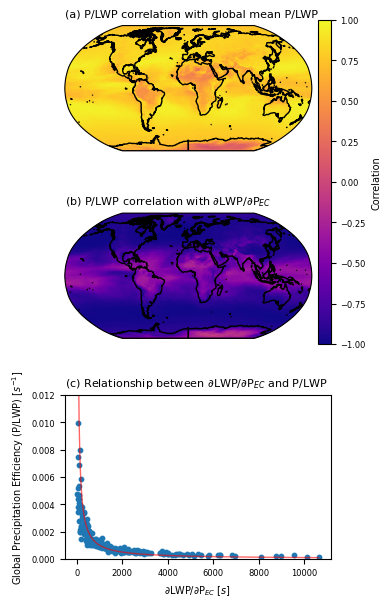

In [6]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import scipy.stats as stats

# Set figure width to 8.7 cm (3.43 inches) — PNAS single-column width
fig = plt.figure(figsize=(3.43, 7))  # Adjust height as needed

# GridSpec: 3 rows, 2 columns (right column reserved for shared colorbar on top row)
gs = gridspec.GridSpec(3, 2, width_ratios=[20, 1], height_ratios=[1, 1, 1.2], hspace=0.35, wspace=0.05)

lat_sh = dLWPmap_gol.lat.shape[0]
lon_sh = dLWPmap_gol.lon.shape[0]
nums = [[0,0], [0,1]]
title_num = ['(a) ', '(b) ']

# PNAS font sizes
title_fontsize = 8
label_fontsize = 7
tick_fontsize = 6

# --- Top two maps ---
for ax_n in range(2):
    ax = fig.add_subplot(gs[ax_n, 0], projection=ccrs.Robinson())
    g = nums[ax_n][0]
    d = nums[ax_n][1]
    
    correlation = np.full((lat_sh, lon_sh), np.nan)
    for i in range(lat_sh):
        for j in range(lon_sh):
            correlation[i, j] = stats.spearmanr(grad[g, :, i, j], dVAR_map_o[d], nan_policy='omit')[0]

    img = ax.pcolormesh(dLWPmap_gol.lon, dLWPmap_gol.lat, correlation,
                        transform=ccrs.PlateCarree(), cmap='plasma',
                        vmin=-1, vmax=1)
    ax.add_feature(cfeature.LAND, facecolor='white')
    ax.add_feature(cfeature.GSHHSFeature(scale='auto', edgecolor='black'))
    ax.set_title(title_num[ax_n] + grad_name[g] + ' correlation with ' + dVar_name[d],
                 fontsize=title_fontsize, loc='left')

# --- Shared vertical colorbar for the two maps ---
cbar_ax = fig.add_subplot(gs[0:2, 1])  # Span both top rows in the second column
cbar = plt.colorbar(img, cax=cbar_ax, orientation='vertical')
cbar.set_label('Correlation', fontsize=label_fontsize)
cbar.ax.tick_params(labelsize=tick_fontsize)

# --- Scatter plot (bottom row, full width) ---
ax_scatter = fig.add_subplot(gs[2, :])  # Bottom row, span both columns
ax_scatter.scatter(PPE_grad_LWP_PRC.data * 86400, pe_gm_o.data, s=10)
x_values = np.sort(PPE_grad_LWP_PRC.data * 86400)
y_values = 1 / x_values
ax_scatter.plot(x_values, y_values, 'r', alpha=0.6, linewidth=1)

ax_scatter.set_ylim(0, 0.012)
ax_scatter.set_xlabel('∂LWP/∂P$_{EC}$ [$s$]', fontsize=label_fontsize)
ax_scatter.set_ylabel('Global Precipitation Efficiency (P/LWP) [$s^{-1}$]', fontsize=label_fontsize)
ax_scatter.set_title('(c) Relationship between ∂LWP/∂P$_{EC}$ and P/LWP', loc='left', fontsize=title_fontsize)
ax_scatter.tick_params(axis='both', labelsize=tick_fontsize)

# Save figure
plt.savefig('final_figures/PE_correlation.png',
            bbox_inches='tight', dpi=600, facecolor='white')
plt.show()
